In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

C:\Users\JingYou\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [25]:
PRE_NAME = "onemin_ohlc_"
BEGIN_TIME = "09:00:00"
END_TIME = "10:30:00"
NUM_CLUSTER = 50
TIME_STEP = 5
def load_data(date_begin='20180612', date_end = '20200301', split_date_begin = '20200302', split_date_end = '20200915', train = True):
# def load_data(date_begin='20180612', date_end = '20180730', split_date_begin = '20180801', split_date_end = '20180830', train = True):

    X = []
    Y = []
    h1, m1, s1 = [int(x) for x in BEGIN_TIME.split(":")]
    h2, m2, s2 = [int(x) for x in END_TIME.split(":")]
    t1 = dt.timedelta(hours = h1, minutes=m1)
    t2 = dt.timedelta(hours = h2, minutes=m2)
    total_mins = (t2-t1).total_seconds()//60
    
    
    for sid in tqdm(os.listdir(os.path.join('dataset'))):
        for file in os.listdir(os.path.join('dataset', sid)):
            curday = file[12:20]
            if (train == True and curday <= date_end and curday >= date_begin) or (train == False and curday >= split_date_begin and curday <= split_date_end):
                df = pd.read_csv(os.path.join('dataset', sid, file))
                df = df
                mask = (df.loc[:, "time"] >= BEGIN_TIME) & (df.loc[:, "time"] <= END_TIME)
                front_df = df[mask].loc[:, "return"]
                front_df = front_df.take(np.arange(0, len(front_df), TIME_STEP))
                end_df = df[~mask].loc[:, "return"]
                if len(front_df) == (90 // TIME_STEP +1):
                    X.append(np.array(front_df))
                    Y.append(np.array(end_df))
    return np.array(X), np.array(Y)

def dtw_d(X, Y):
    manhattan_distance = lambda x, y: np.abs(x - y)
    d, cost_matrix, acc_cost_matrix, path = dtw(X, Y, dist=manhattan_distance)
    return d

def dtw_affinity(X):
    return pairwise_distances(X, metric=dtw_d)

def fastdtw_d(X, Y):
    return fastdtw(X, Y, dist=euclidean)[0]

def fastdtw_affinity(X):
    return pairwise_distances(X, metric=fastdtw_d)

In [26]:
X, Y = load_data()

100%|██████████| 13/13 [00:14<00:00,  1.13s/it]


In [27]:
X_test, Y_test = load_data(train=False)

100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


In [77]:
print(X.shape)

(2990, 19)


In [78]:
print(X_test.shape)

(915, 19)


t1 = time.time()
fastdtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)
t1 = time.time()
dtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)

t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = fastdtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

In [28]:
t1 = time.time()
km = TimeSeriesKMeans(n_clusters=50, metric="dtw", n_jobs=5)
X_label = km.fit_predict(X)
t2 = time.time()
print("time", t2-t1)

time 148.217383146286


t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = dtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

In [19]:
X_label

array([ 5, 26, 38, 32, 37, 28, 20,  3,  8,  0, 40,  7, 11, 24, 41, 44, 45,
        0, 12, 41,  9, 33, 33, 36, 14, 12, 33, 46, 48, 21, 46, 33, 12, 46,
       21, 14, 21,  0, 28, 41, 21, 33, 27, 49, 22, 12, 14, 33, 42, 14, 21,
       21, 25, 21, 18, 18, 12,  9, 10, 32, 35, 30, 47, 23,  0, 20, 23,  8,
       42, 31, 15, 24, 37, 21, 22, 42, 29, 41, 12, 29, 32,  9, 47, 49, 22,
       10, 47, 25, 42, 42, 49, 28, 48, 29, 12,  5,  5, 24, 17,  8,  9,  4,
       48, 49, 34, 39,  0, 20, 28, 35, 39, 14,  1, 39,  6, 33, 45,  9, 43,
       17, 28, 19,  4,  4, 22, 39, 24, 44, 13,  0,  4, 41, 22, 39, 42, 18,
       26, 39, 13, 28, 29, 22, 12, 20, 46, 30, 45, 36, 48, 19, 17,  2, 47,
       39, 42,  4, 28, 22, 26, 13,  4, 33, 12, 47, 47,  4, 35, 16, 49, 21,
       11,  8, 28, 39, 27, 46, 22,  5, 39], dtype=int64)

In [29]:
pickle.dump(X, open(os.path.join('dataset_pk',"X_ts.pk"), "wb"))
pickle.dump(Y, open(os.path.join('dataset_pk',"Y_ts.pk"), "wb"))


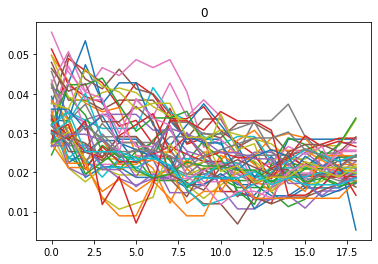

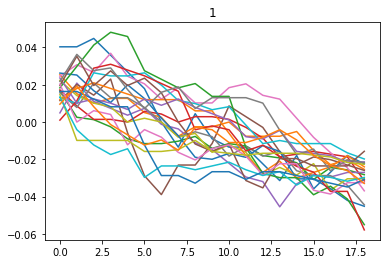

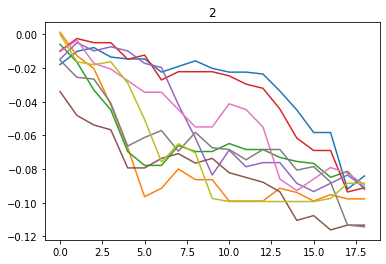

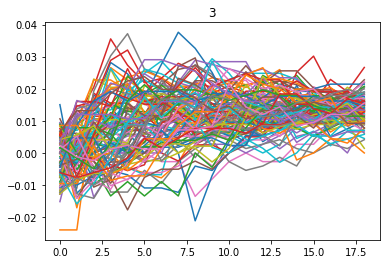

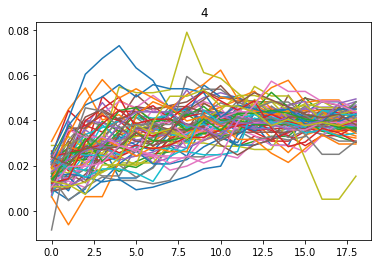

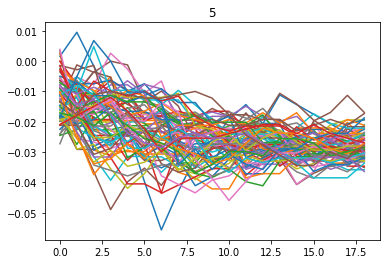

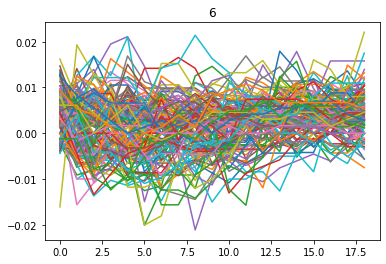

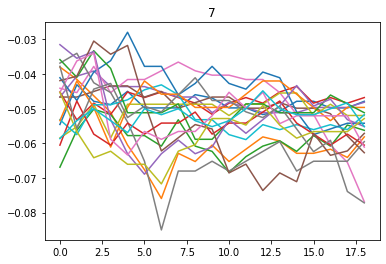

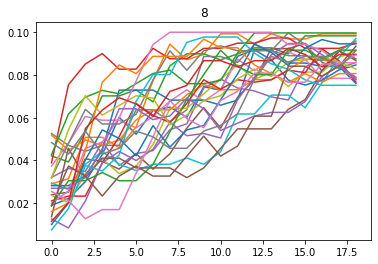

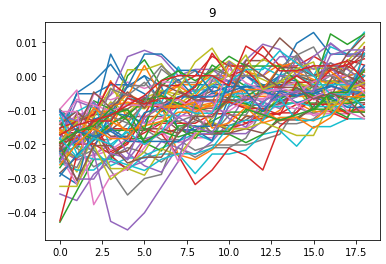

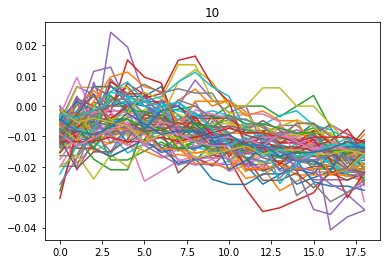

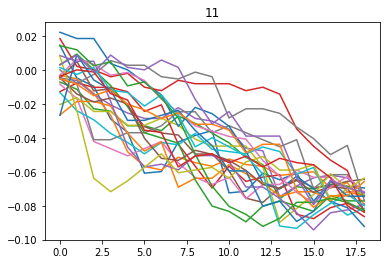

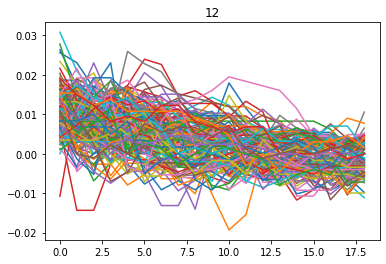

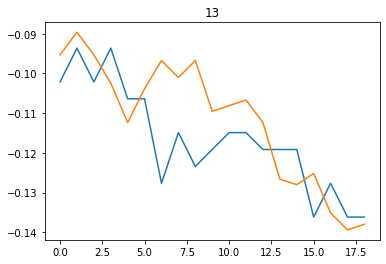

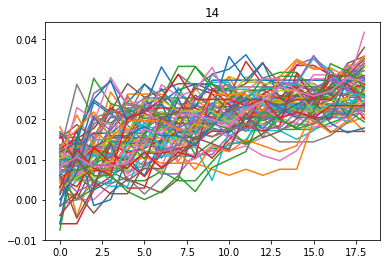

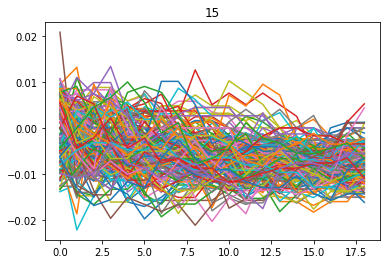

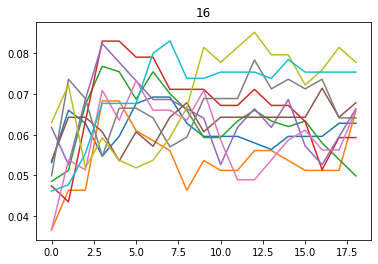

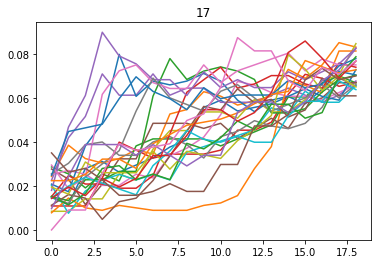

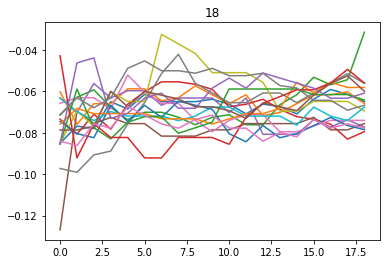

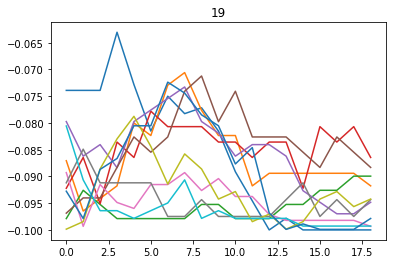

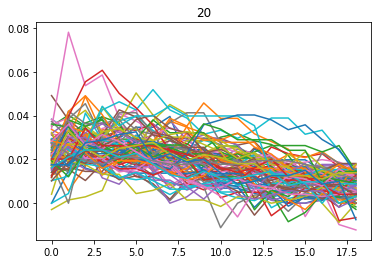

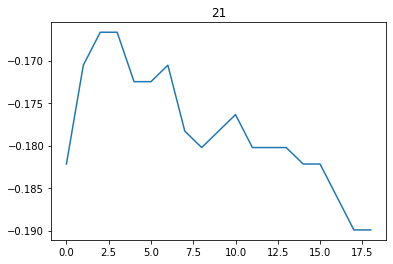

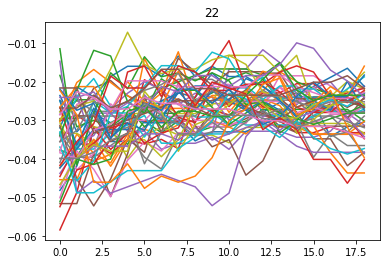

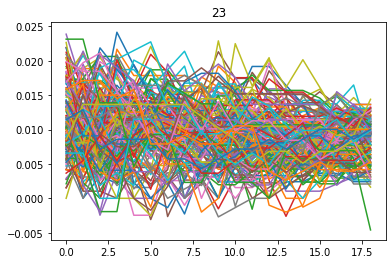

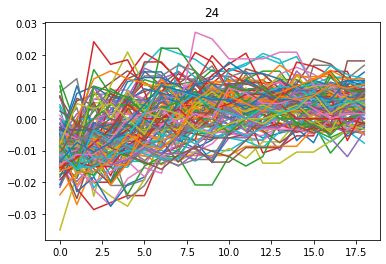

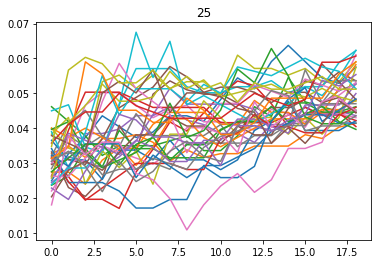

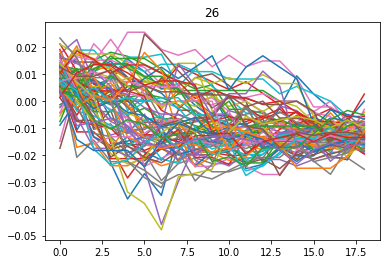

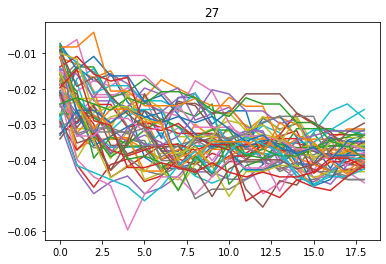

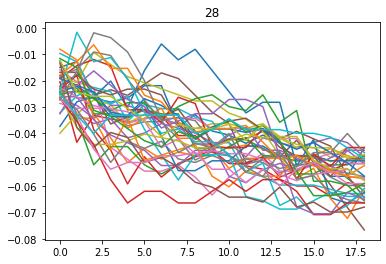

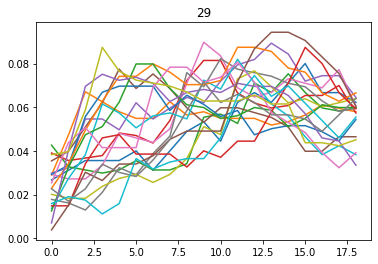

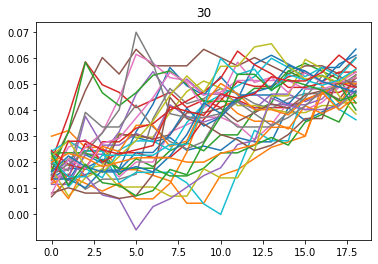

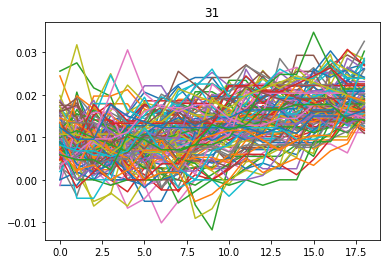

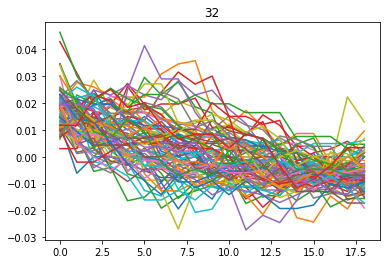

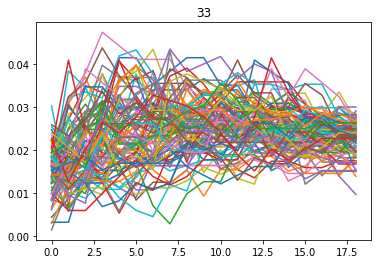

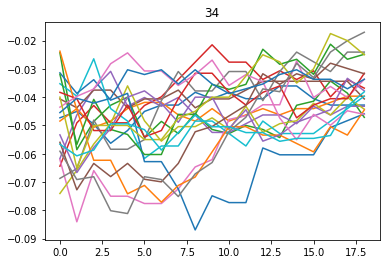

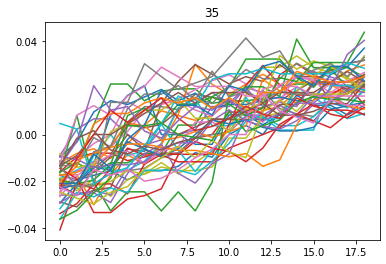

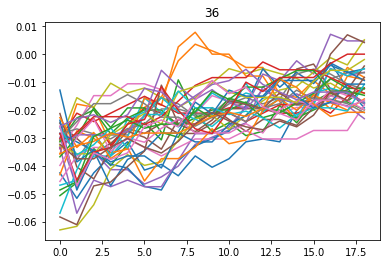

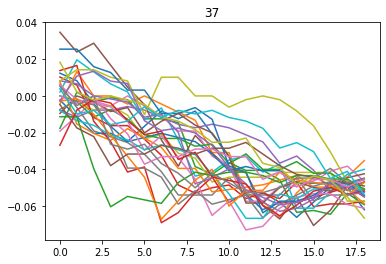

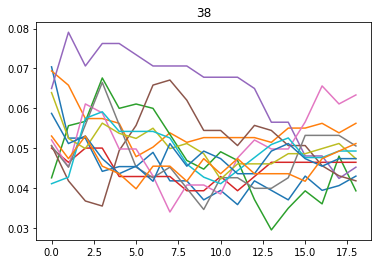

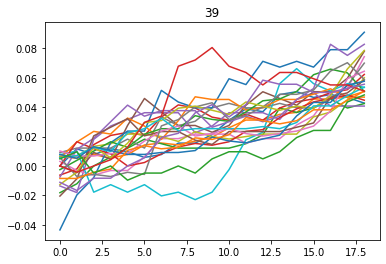

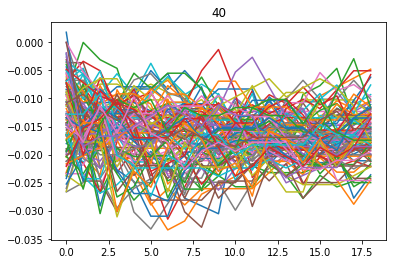

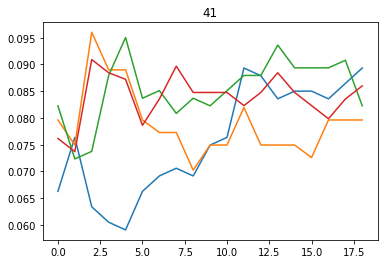

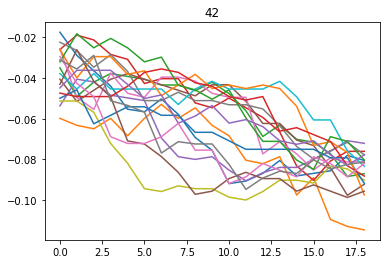

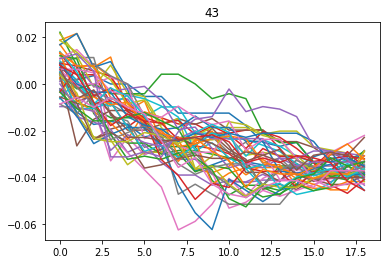

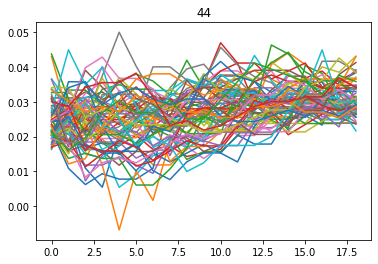

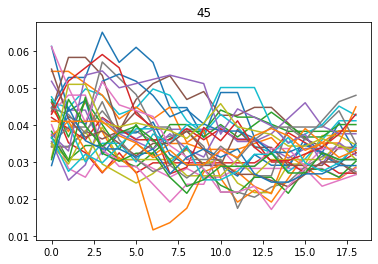

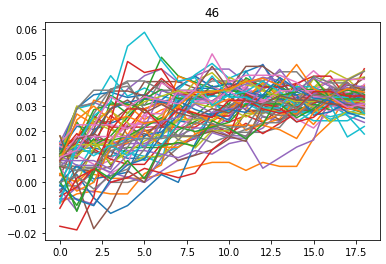

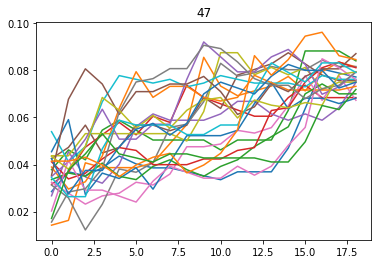

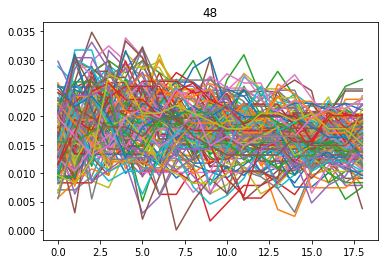

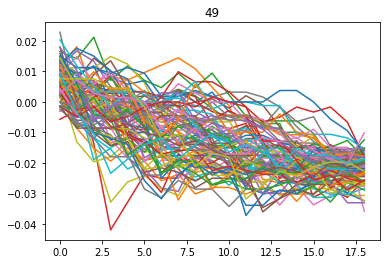

In [30]:
for n in range(NUM_CLUSTER):
    plt.title(n)
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == n:
            plt.plot(X[i])
    plt.show()

In [24]:
def make_long_simple(y, cost):
    return y.max() - y[0] - cost
def make_short_simple(y, cost):
    return y[0] - y.min() - cost
def make_long_max_lost(y, cost):
    return y.min() - y[0] - cost
def make_short_max_lost(y, cost):
    return y[0] - y.max() - cost
def make_long(y, cost, exp_profit):
    if (y-y[0]-cost >= exp_profit).any():
        return exp_profit
    else:
        return y[-1] - y[0] - cost

def make_short(y, cost, exp_profit):
    if (y[0]-y-cost >= exp_profit).any():
        return exp_profit
    else:
        return -y[-1] + y[0] - cost

def make_table(X, X_label):
    X_mean = np.zeros((len(X_label), len(X[0])))
    for i in range(NUM_CLUSTER):
        X_mean[X_label[i]] = X[X_label==i].mean(axis=0)
    return X_mean
X_table = make_table(X, X_label)
pickle.dump(X_table, open(os.path.join('dataset_pk',"X_ts_tabel.pk"), "wb"))

In [31]:
len(X)

2990

In [32]:
Y.shape

(2990,)

In [34]:
pickle.dump(km, open("km.pk", 'wb'))

In [ ]:
ac = pickle.load(open("ac_model2.pc", 'rb'))

In [35]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long_simple(Y[i], 0.002)
    profit_short_array[X_label[i]] += make_short_simple(Y[i], 0.002)
    lost_long_array[X_label[i]] += make_long_max_lost(Y[i], 0.002)
    lost_short_array[X_label[i]] += make_short_max_lost(Y[i], 0.002)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print('best avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
print('best avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
print('worst avg long return', sorted(lost_long_array/num_long_array)[::-1][:10])
print('worst avg short return', sorted(lost_short_array/num_short_array)[::-1][:10])
print(num_long_array)
print(num_short_array)

best avg long return [0.021194099752034408, 0.020763353904601125, 0.020360477816426407, 0.019294755001361942, 0.01887793414480738, 0.018488447782186727, 0.017907221528576166, 0.016906250877234463, 0.016518863371604707, 0.015706046211639752]
best avg short return [0.029578135767439888, 0.025054997229252654, 0.022557594221423186, 0.020985869600696185, 0.020947603077118133, 0.020387615445254834, 0.019732372719261353, 0.019502116439357068, 0.018747385391597773, 0.01854240272812857]
worst avg long return [-0.002, -0.003422475106685625, -0.006510313693943578, -0.011741942174104167, -0.01201421856240897, -0.012107439924321587, -0.012423367965318217, -0.01316772506527108, -0.013280767583273095, -0.013455208573979657]
worst avg short return [-0.002972632651363596, -0.009525015374640252, -0.0108913009866932, -0.011072430532537564, -0.011321236560223276, -0.011676509306748675, -0.011689922480620172, -0.01174874233798003, -0.011805065754804193, -0.012141338716837933]
[ 50  22   9 108  69  76 153  

In [ ]:
def find_cluster(X, X_table):
    prev_min = dtw_d(X, X_table[0])
    prev_min_arg = 0
    for i in range(1, NUM_CLUSTER):
        cur_min = dtw_d(X, X_table[i])
        if prev_min >= cur_min:
            prev_min = cur_min
            prev_min_arg = i
    return prev_min_arg

In [ ]:
def find_cluster_L2(X, X_table):
    prev_min = dtw_d(X, X_table[0])
    prev_min_arg = 0
    for i in range(1, NUM_CLUSTER):
        cur_min = np.sum((X - X_table[i])**2)
        if prev_min >= cur_min:
            prev_min = cur_min
            prev_min_arg = i
    return prev_min_arg

In [ ]:
find_cluster_L2(X_test[0], X_table)

In [66]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long(Y[i], 0.002, 0.025)
    profit_short_array[X_label[i]] += make_short(Y[i], 0.002, 0.025)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print('avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
print('avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
print(num_long_array)
print(num_short_array)
best_long_cluster = np.argsort(profit_long_array/num_long_array)[::-1]
best_short_cluster = np.argsort(profit_short_array/num_long_array)[::-1]

avg long return [0.010077524893314375, 0.006605943567794233, 0.006379363044424753, 0.0038867811366756094, 0.0032247167877424215, 0.0028798713954068405, 0.0006687185973834357, 0.000599220127616181, 0.0004644332728053279, -0.0009242782663277505]
avg short return [0.008449525540097277, 0.00644634655882154, 0.006206837151328408, 0.005254538874422361, 0.00499954363311584, 0.004568236113864187, 0.004540277842284976, 0.004339154673810556, 0.004190430166371871, 0.003816052381514237]
[ 50  22   9 108  69  76 153  20  28  66  71  25 166   2  77 175  10  27
  18  11  91   1  58 172 132  39  86  54  40  20  34 123  86  96  21  47
  37  30  12  25 107   4  18  47  74  33  68  23 139  90]
[ 50  22   9 108  69  76 153  20  28  66  71  25 166   2  77 175  10  27
  18  11  91   1  58 172 132  39  86  54  40  20  34 123  86  96  21  47
  37  30  12  25 107   4  18  47  74  33  68  23 139  90]


In [37]:
best_long_cluster

array([13, 16, 30, 35, 14, 17, 47, 34, 36, 46,  3,  4,  8, 21, 31, 37, 26,
       44, 40, 24,  6,  9, 22, 23, 25, 33, 12, 29, 15, 19, 39,  2, 48,  5,
       49,  1, 28,  7, 42, 38, 45, 11, 32, 27, 43,  0, 10, 18, 41, 20],
      dtype=int64)

In [45]:
Y_pred = km.predict(X.reshape(len(X), len(X[0]), 1))

In [46]:
X_label

array([37, 37, 11, ..., 15,  5, 49], dtype=int64)

In [47]:
Y_pred

array([37, 37, 11, ..., 15,  5, 49], dtype=int64)

In [48]:
(~X_label == Y_pred).any()

False

In [49]:
y_test_pred =  km.predict(X_test.reshape(len(X_test), len(X_test[0]), 1))

In [72]:
def evaluate_km(X_test, Y_test, exp_profit=0.025):
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    lost_long_array = np.zeros(NUM_CLUSTER)
    lost_short_array = np.zeros(NUM_CLUSTER)
    num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
    for i in tqdm(range(len(X_test))):
#         X_label = find_cluster(X_test[i], X_table)
        profit_long_array[y_test_pred[i]] += make_long(Y_test[i], 0.002, exp_profit)
        profit_short_array[y_test_pred[i]] += make_short(Y_test[i], 0.002, exp_profit)
        num_exchange_array[y_test_pred[i]] += 1
    return profit_long_array, profit_short_array, num_exchange_array 

In [73]:
profit_long_array, profit_short_array, num_long_array  = evaluate_km(X_test, Y_test)

100%|██████████| 915/915 [00:00<00:00, 91749.46it/s]


In [74]:
for i in range(len(best_long_cluster)):
    print(i, profit_short_array[best_short_cluster[i]], num_long_array[best_long_cluster[i]])

0 0.34508097045161595 0
1 0.18938648080775158 6
2 -0.010529722071541842 10
3 0.036528900149830165 4
4 0.07250736296688591 28
5 -0.0020598496390311673 10
6 0.050530227111290224 8
7 0.06351312540245153 2
8 0.054961585287216785 11
9 0.040947813822284906 18
10 0.10389541456151985 26
11 -0.12979030898019045 14
12 -0.2519631183581175 11
13 0.0153278719050577 0
14 0.025 47
15 -0.0021932788861600914 7
16 0.06482091778780918 25
17 0.04034741093345525 26
18 -0.16346685308791192 40
19 -0.09624023429392473 25
20 0.1459861023494149 38
21 0.04383806957373836 15
22 0.07501167863023922 14
23 0.21022321861346477 61
24 0.0 6
25 -0.009938784531648093 26
26 -0.045371159143095335 61
27 -0.1702886075111703 4
28 -0.006227698560228654 53
29 0.0007748602114759431 7
30 -0.057359683794466404 5
31 -0.20905627589277787 10
32 0.0 51
33 0.08815231945281841 26
34 -0.026262661465888314 25
35 -0.07070166496447491 2
36 -0.07955075886623944 3
37 -0.03665418540283779 3
38 0.0829581908537636 4
39 -0.01546492343990813 6
40 

In [75]:
for j in range(10):
    i = best_short_cluster[j]
    if num_long_array[i]:
        print(i, profit_short_array[i], num_long_array[i], profit_short_array[i]/num_long_array[i])

20 0.34508097045161595 40 0.0086270242612904
10 0.18938648080775158 23 0.00823419481772833
2 -0.010529722071541842 10 -0.001052972207154184
42 0.036528900149830165 4 0.009132225037457541
43 0.07250736296688591 12 0.0060422802472404925
32 -0.0020598496390311673 25 -8.239398556124669e-05
7 0.050530227111290224 3 0.016843409037096743
49 0.06351312540245153 25 0.0025405250160980613
27 0.054961585287216785 14 0.003925827520515485
28 0.040947813822284906 3 0.013649271274094968


In [79]:
for j in range(10):
    i = best_long_cluster[j]
    if num_long_array[i]:
        print(i, profit_long_array[i], num_long_array[i], profit_long_array[i]/num_long_array[i])

16 0.0355594110408769 6 0.005926568506812817
30 -0.13469202975824396 10 -0.013469202975824397
35 0.004118305589036225 4 0.0010295763972590563
14 0.001566826350983968 28 5.595808396371314e-05
17 -0.012217185064151937 10 -0.0012217185064151937
47 -0.03368575438056312 8 -0.00421071929757039
34 0.03532783694034124 2 0.01766391847017062
36 0.008931724488844274 11 0.0008119749535312977
46 -0.11327635210148142 18 -0.006293130672304523


In [87]:
num_exchange = 0
profit = 0
for n in range(5):
    i = best_short_cluster[n]
    num_exchange += num_long_array[i]
    profit += profit_short_array[i]
print("avg_profit_10best_clustering:", profit / num_exchange)

avg_profit_10best_clustering: 0.007112067329264515


In [84]:
num_exchange = 0
profit = 0
for n in range(5):
    i = best_short_cluster[n]
    num_exchange += num_long_array[i]
    profit += profit_short_array[i]
print("avg_profit_10best_clustering:", profit / num_exchange)

avg_profit_10best_clustering: 0.007112067329264515


In [85]:
num_exchange = 0
profit = 0
for n in range(10):
    i = best_short_cluster[n]
    num_exchange += num_long_array[i]
    profit += profit_short_array[i]
print("avg_profit_10best_clustering:", profit / num_exchange)

avg_profit_10best_clustering: 0.005288471033262604


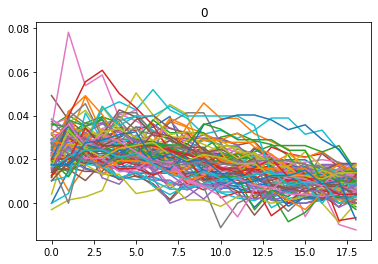

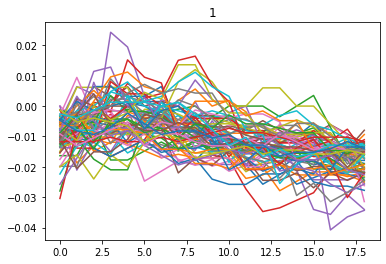

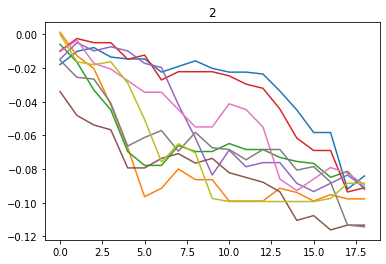

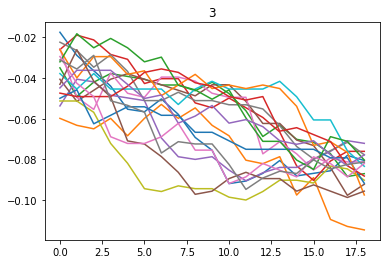

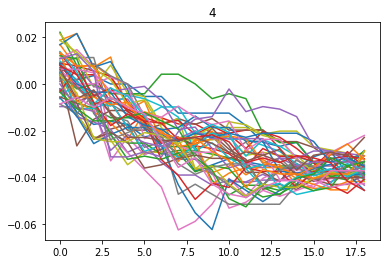

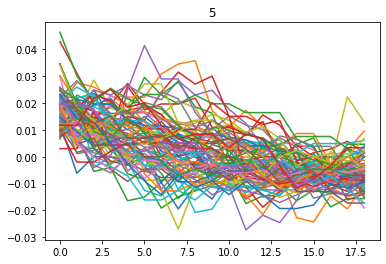

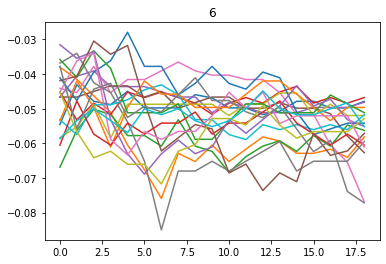

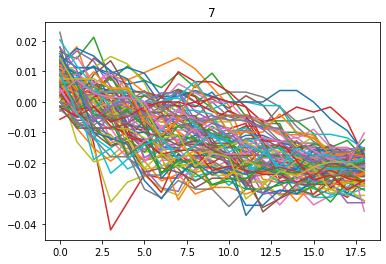

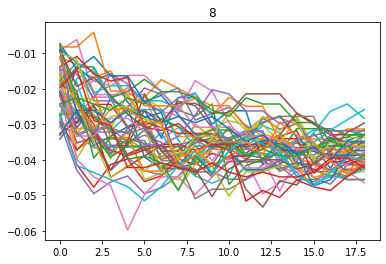

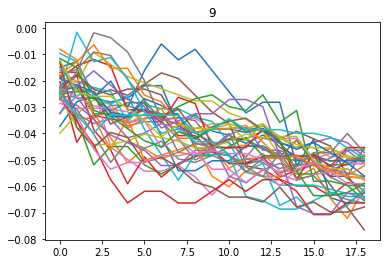

In [76]:
for n in range(10):
    plt.title(n)
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == best_short_cluster[n]:
            plt.plot(X[i])
    plt.show()

In [ ]:
print()